# Ejemplo de código de optimizador de prompts
Este código muestra cómo optimizar un prompt para un modelo de lenguaje GPT-3.5, utilizando GPT-4 como optimizador. El codigo esta basado en el paper [Large Language Models as Optimizers. Yang et al. (2023).](https://arxiv.org/pdf/2309.03409.pdf)


## 1.- Setup inicial

### 1.1- Instalar librerías

In [ ]:
#! pip install openai
#! pip install tenacity
#! pip install python-dotenv

### 1.2.- Cargar librerías

In [ ]:
import json
import openai
import os
import numpy as np
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
from tenacity import retry, wait_random_exponential, stop_after_attempt

### 1.3.- Variables de entorno

In [ ]:
# Load secrets and config from .env file
load_dotenv()

# OpenAI API
openai.api_key = os.getenv("OPENAI_API_KEY")
embedding_model = os.getenv("OPENAI_EMBEDDING_MODEL")
print("OpenAI API key: {}".format(openai.api_key[:5] + '...' + openai.api_key[-5:]))

# Model endpoint names
gpt35_model = os.getenv("OPENAI_GPT35_MODEL")
gpt35_16k_model = os.getenv("OPENAI_GPT35_16K_MODEL")
gpt4_model = os.getenv("OPENAI_GPT4_MODEL")
print("GPT-3.5-Turbo model: {}".format(gpt35_model))
print("GPT-3.5-Turbo-16k model: {}".format(gpt35_16k_model))
print("GPT-4 model: {}".format(gpt4_model))

### 1.4.- Clase para logs

In [ ]:
class Logger:
    def __init__(self, log_file=None, log_dir='./logs'):
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        
        if log_file is None:
            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            log_file = f"log_{timestamp}.log"
        
        self.log_file = os.path.join(log_dir, log_file)

    def _write_log(self, level, msg, verbose):
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_entry = f"{timestamp} [{level}] {msg}\n"
        with open(self.log_file, "a") as f:
            f.write(log_entry)
        if verbose:
            print(log_entry.strip())

    def info(self, msg, verbose=False):
        self._write_log("INFO", msg, verbose)

    def warn(self, msg, verbose=False):
        self._write_log("WARN", msg, verbose)

    def error(self, msg, verbose=True):
        self._write_log("ERROR", msg, verbose)
        
logger = Logger()
logger.info("Logger initialized", verbose=True)

### 1.5.- Clase para generación de texto con modelos GPT

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(3))
def generate_text(prompt, model=gpt35_model, messages=[], max_tokens=250, temperature=0.5, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0, stop=None):
    _messages = []
    _messages.extend(messages)
    _messages.append({"role": "user", "content": prompt})
    
    _log_message = "\n\n============================ PROMPT ============================\n"
    for message in _messages:
        _log_message += f"{message['role']}: {message['content']}\n"
    logger.info(_log_message)
        
    response = openai.ChatCompletion.create(
        model=model,
        messages=_messages,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
        stop=stop
    )
    _log_message = "\n\n============================ RESPONSE ============================\n"
    _log_message += f"{response}\n"
    logger.info(_log_message)
    return response["choices"][0]["message"]["content"]

## 2.- Ejemplo de Optimización de Prompts
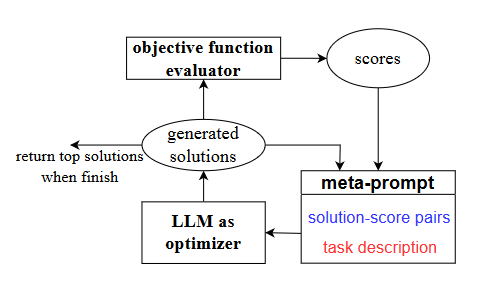

### 2.1.- Clase para generación de nuevas prompts
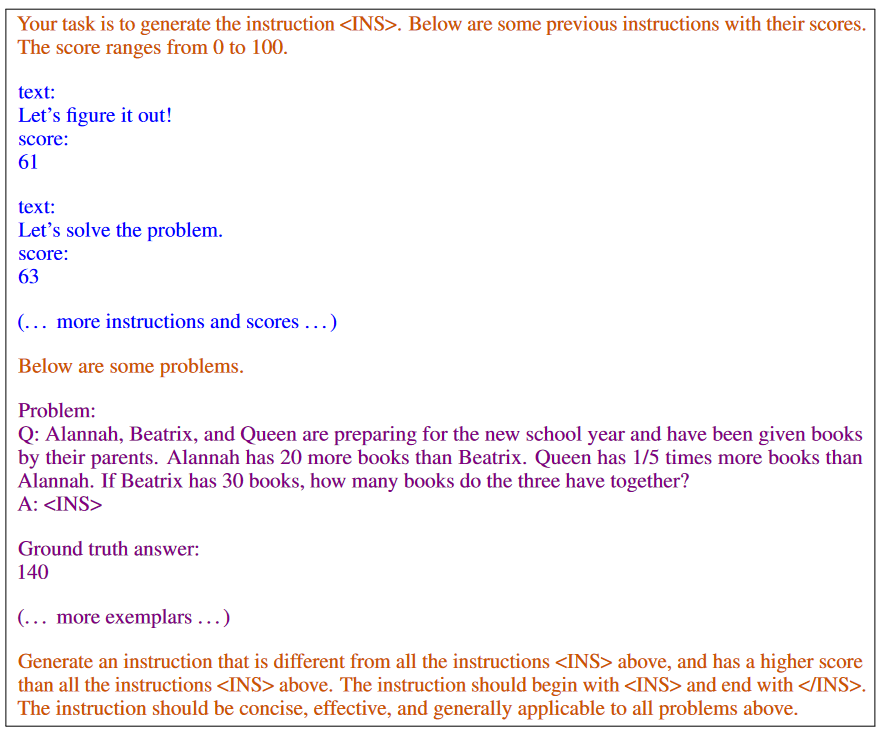

In [ ]:
def generate_prompt(instructions, problems, top_instructions=10, top_problems=5):
    # Sort instructions by score and select top results
    instructions = sorted(instructions, key=lambda x: x['score'], reverse=True)[:top_instructions]
    instructions_str = "\n".join([f"{i['prompt']} (score: {i['score']})" for i in instructions])
    
    # Filter top 5 problems
    problems = problems[:top_problems]
    
    problems_str = "\n".join([f"Q:\n{i['question']}\nA:<INS>\nGround Truth Answer:\n{i['ground_truth']}" for i in problems])
    
    prompt = f"Your task is to generate the instruction <INS>. Below are some previous instructions with their scores. The score ranges from 0 to 100.\n\n{instructions_str}\n\nBelow are some problems.\n{problems_str}\n\nGenerate an instruction that is different from all the instructions <INS> above, and has a higher score than all the instructions <INS> above. The instruction should begin with <INS> and end with </INS>. The instruction should be concise, effective, and generally applicable to all problems above."
    
    new_prompt = generate_text(prompt, model=gpt4_model, temperature=1)
    new_prompt = new_prompt.replace("<INS>", "").replace("</INS>", "")
    return new_prompt

### 2.2.- Clase para evaluación de respuestas

In [ ]:
def evaluate_answer(answer, ground_truth):
    logger.info("Evaluating answer: {}".format(answer))
    logger.info("Ground Truth: {}".format(json.dumps(ground_truth, indent=2)))
    # load answer as json
    try:
        answer = json.loads(answer)
    except:
        logger.info("  answer is not valid json")
        return 0
    
    # compare each answer field with each ground truth field
    score = 0
    for key in answer.keys():
        if key in ground_truth.keys():
            if answer[key] == ground_truth[key]:
                score += 1
            else:
                logger.info("  field '{}' does not match ground truth".format(key))
        else:
            logger.info("  field '{}' not found in ground truth".format(key))
    
    # normalize score
    score = score / len(ground_truth.keys())
    return score * 100

### 2.3.- Clase para testear nuevas prompts

In [ ]:
def test_prompt(prompt, problems, consistency_iterations=3):
    logger.info(f"Testing prompt with '{consistency_iterations}' consistency iterations:\n{prompt}", verbose=True)

    all_answer_scores = []
    problem_avg_scores = []

    for i, problem in enumerate(problems):
        full_prompt = f"<INVOICE>\n{problem['question']}\n</INVOICE>\n{prompt}"
        answer_scores = []

        for j in range(consistency_iterations):
            answer = generate_text(full_prompt, model=gpt35_model, temperature=0.3)
            score = evaluate_answer(answer, problem['ground_truth'])
            answer_scores.append(score)
            logger.info(f"  Problem {i+1}/{len(problems)} - Iteration {j+1}/{consistency_iterations} -> Score: {score:.3f}", verbose=True)

        problem_avg_score = np.mean(answer_scores)
        problem_std_dev = np.std(answer_scores)
        logger.info(f"  Problem {i+1} Avg Score: {problem_avg_score:.3f} - Std Dev: {problem_std_dev:.3f}", verbose=True)

        problem_avg_scores.append(problem_avg_score)
        all_answer_scores.append(answer_scores)

    overall_avg_score = np.mean(problem_avg_scores)
    overall_std_dev = np.mean([np.std(ans) for ans in all_answer_scores])
    logger.info(f"Overall Avg Score: {overall_avg_score:.3f} - Overall Std Dev: {overall_std_dev:.3f}\n", verbose=True)

    return overall_avg_score

### 2.4.- Condiciones iniciales

In [ ]:
FIRST_PROMPT = """You are extracting information from an <INVOICE>. Extract the following information and present it in a table in JSON format: Invoice Number, Invoice Date, Due Date, Total Amount, Tax Amount (or IVA), Recipient Name, Recipient Tax Number (or RUT), Sender Name, Sender Tax Number (or RUT). Use this format for dates: YYYY-MM-DD. Use this format for money: $1.000.000,00."""

In [ ]:
instructions = []

In [ ]:
import json
with open('problem_examples.json') as f:
    problems = json.load(f)

### 2.5.- Evaluación inicial

In [ ]:
first_prompt_score = test_prompt(FIRST_PROMPT, problems)
instructions.append({"prompt": FIRST_PROMPT, "score": first_prompt_score})

### 2.6.- Loop de optimización

In [ ]:
MAX_ITERATIONS = 3

for i in range(MAX_ITERATIONS):
    logger.info(f"======================== NEW PROMPT (ITERATION {i+1}/{MAX_ITERATIONS}) =========================", verbose=True)
    new_prompt = generate_prompt(instructions, problems)
    success_score = test_prompt(new_prompt, problems)
    instructions.append({"prompt": new_prompt, "score": success_score})
    logger.info("=============================================================================", verbose=True)

### 2.7.- Resultados

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.DataFrame(instructions)
df = df.sort_values(by=['score'], ascending=False)
df = df.reset_index(drop=True)
df.index += 1
df = df[['score', 'prompt']]
df